In [1]:
%cd ../

/mnt2/kireev/pycharm-deploy/pytorch-lifestream/experiments/scenario_gender


In [2]:
import random
import math

In [3]:
def rand_log(a, b):
    la, lb = math.log(a), math.log(b)
    return round(math.exp(random.random() * (lb - la) + la), 6)

In [4]:
def rand_int(a, b):
    return round(random.random() * (b - a) + a, 6)

In [36]:
params = [
    {
        'lambd': rand_log(0.001, 0.1),
        'hidden_size': int(rand_log(256, 2048)),
        'prj_size': 0 if random.random() < 0.5 else int(rand_log(64, 512)),
        'batch_size': int(rand_log(32, 512)),
        'lr': rand_log(0.00002, 0.2),
        'weight_decay': 0 if random.random() < 0.5 else rand_log(0.0001, 0.1),
        'step_size': [10, 20, 30][random.randint(0, 2)],
        'step_gamma': rand_int(0.4, 1.0),
    }
    for _ in range(30)
]

In [37]:
with open('bin/scen_bt_tuning_1.sh', 'wt') as f:
    for p in params:
        name = '-'.join([f'{k}_{v}' for k, v in p.items()])
        
        if p['prj_size'] == 0:
            prj_s = '  '
        else:
            prj_s = f""" "params.head_layers=[[Linear, {{in_features: {p['hidden_size']}, out_features: {p['prj_size']}, bias: false}}], [BatchNorm1d, {{num_features: {p['prj_size']}}}], [ReLU, {{ }}], [Linear, {{in_features: {p['prj_size']}, out_features: {p['prj_size']}, bias: false}}], [BatchNorm1d, {{num_features: {p['prj_size']}, affine: False}}]]" """
        
        f.write(f"""
    export SC_SUFFIX="bt_tuning_{name}"
    python ../../pl_train_module.py \\
        logger_name=${{SC_SUFFIX}} \\
        params.train.lambd={p['lambd']} \\
        params.rnn.hidden_size="{p['hidden_size']}" \\
        {prj_s} \\
        data_module.train.batch_size={p['batch_size']} \\
        params.train.lr={p['lr']} \\
        params.train.weight_decay={p['weight_decay']} \\
        params.lr_scheduler.step_size={p['step_size']} \\
        params.lr_scheduler.step_gamma={p['step_gamma']} \\
        model_path="models/gender_mlm__$SC_SUFFIX.p" \\
        --conf "conf/barlow_twins_params.hocon"
    python ../../pl_inference.py \
        inference_dataloader.loader.batch_size=500 \\
        model_path="models/gender_mlm__$SC_SUFFIX.p" \\
        output.path="data/emb__${{SC_SUFFIX}}" \\
        --conf "conf/barlow_twins_params.hocon"

        """)

```
sh bin/scen_bt_tuning_3.sh

rm results/res_bt_tuning.txt
# rm -r conf/embeddings_validation.work/
python -m embeddings_validation \
    --conf conf/embeddings_validation_short.hocon --workers 10 --total_cpu_count 20 \
    --conf_extra \
      'report_file: "../results/res_bt_tuning.txt",
      auto_features: ["../data/emb__bt_tuning_*.pickle", "../data/barlow_twins_embeddings.pickle"]'
less -S results/res_bt_tuning.txt


```

In [5]:
import pandas as pd

In [45]:
df = pd.read_fwf('results/res_bt_tuning.txt').iloc[10:95, :2]
df.columns = ['name', 'm']
df

,name,m
10,emb__bt_tuning_lambd_0.001079-hidden_size_384-...,0.691
11,emb__bt_tuning_lambd_0.001107-hidden_size_412-...,0.628
12,emb__bt_tuning_lambd_0.001168-hidden_size_315-...,0.789
13,emb__bt_tuning_lambd_0.001206-hidden_size_407-...,0.667
14,emb__bt_tuning_lambd_0.001311-hidden_size_344-...,0.696
...,...,...
90,emb__bt_tuning_lambd_0.078426-hidden_size_506-...,0.655
91,emb__bt_tuning_lambd_0.078698-hidden_size_1976...,0.706
92,emb__bt_tuning_lambd_0.079424-hidden_size_640-...,0.821
93,emb__bt_tuning_lambd_0.081247-hidden_size_842-...,0.835


In [74]:
df.iloc[0, 0]

'emb__bt_tuning_lambd_0.001079-hidden_size_384-prj_size_396-batch_size_230-lr_2.2e-05-weight_decay_0-step_size_30-step_gamma_0.423246'

<AxesSubplot:xlabel='n'>

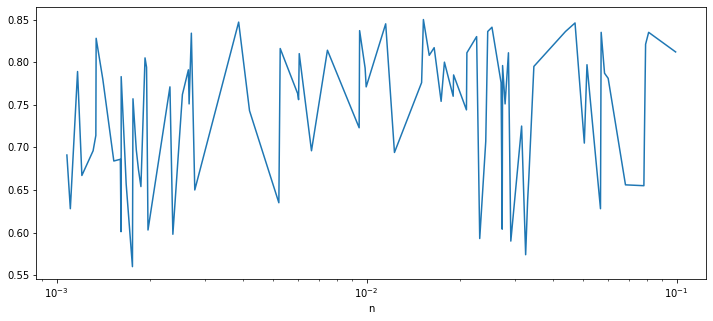

In [71]:
pd.concat([
    df.name.str.replace('e-', 'e^').str.split(r'-', expand=True),
    df.m,
], axis=1).rename(columns={0: 'k'}).set_index('k')['m'].reset_index() \
    .assign(n=lambda x: pd.to_numeric(x['k'].str.split('_').str[-1])) \
    .set_index('n').sort_index()['m'].astype(float).plot(figsize=(12, 5), logx=True)

<AxesSubplot:xlabel='n'>

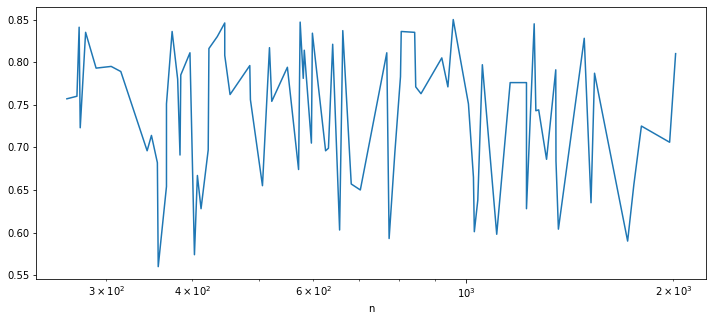

In [72]:
pd.concat([
    df.name.str.replace('e-', 'e^').str.split(r'-', expand=True),
    df.m,
], axis=1).rename(columns={1: 'k'}).set_index('k')['m'].reset_index() \
    .assign(n=lambda x: pd.to_numeric(x['k'].str.split('_').str[-1])) \
    .set_index('n').sort_index()['m'].astype(float).plot(figsize=(12, 5), logx=True)

<AxesSubplot:xlabel='n'>

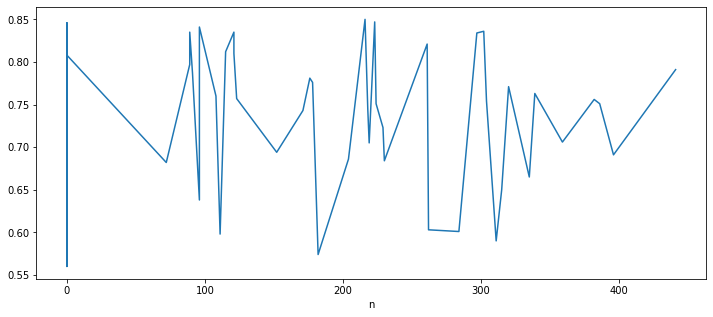

In [76]:
pd.concat([
    df.name.str.replace('e-', 'e^').str.split(r'-', expand=True),
    df.m,
], axis=1).rename(columns={2: 'k'}).set_index('k')['m'].reset_index() \
    .assign(n=lambda x: pd.to_numeric(x['k'].str.split('_').str[-1])) \
    .set_index('n').sort_index()['m'].astype(float).plot(figsize=(12, 5))

<AxesSubplot:xlabel='n'>

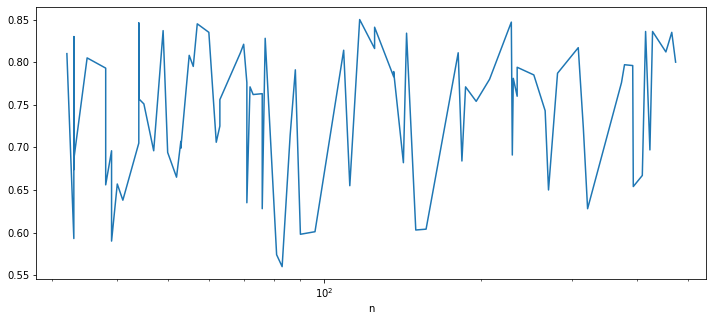

In [77]:
pd.concat([
    df.name.str.replace('e-', 'e^').str.split(r'-', expand=True),
    df.m,
], axis=1).rename(columns={3: 'k'}).set_index('k')['m'].reset_index() \
    .assign(n=lambda x: pd.to_numeric(x['k'].str.split('_').str[-1])) \
    .set_index('n').sort_index()['m'].astype(float).plot(figsize=(12, 5), logx=True)

<ipython-input-87-d6d811f766c3>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  .assign(k=lambda x: x['k'].str.replace('^', '-'), regex=False) \


<AxesSubplot:xlabel='n'>

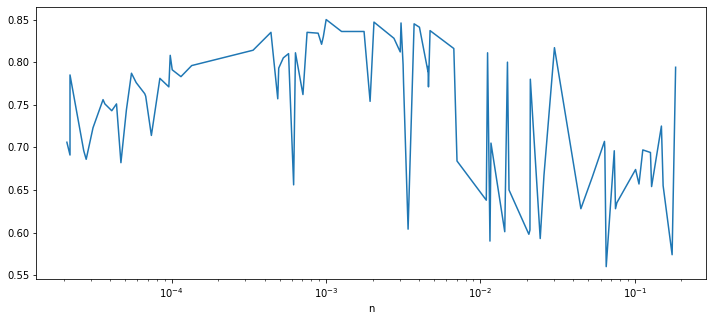

In [87]:
pd.concat([
    df.name.str.replace('e-', 'e^').str.split(r'-', expand=True),
    df.m,
], axis=1).rename(columns={4: 'k'}).set_index('k')['m'].reset_index() \
    .assign(k=lambda x: x['k'].str.replace('^', '-'), regex=False) \
    .assign(n=lambda x: pd.to_numeric(x['k'].str.split('_').str[-1])) \
    .set_index('n').sort_index()['m'].astype(float).plot(figsize=(12, 5), logx=True)

<ipython-input-88-7ee949e0fc59>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  .assign(k=lambda x: x['k'].str.replace('^', '-'), regex=False) \


<AxesSubplot:xlabel='n'>

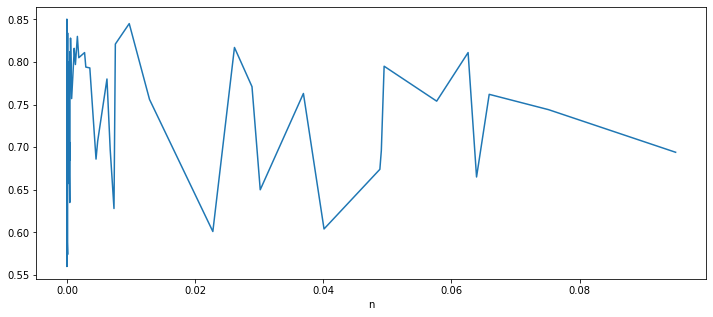

In [88]:
pd.concat([
    df.name.str.replace('e-', 'e^').str.split(r'-', expand=True),
    df.m,
], axis=1).rename(columns={5: 'k'}).set_index('k')['m'].reset_index() \
    .assign(k=lambda x: x['k'].str.replace('^', '-'), regex=False) \
    .assign(n=lambda x: pd.to_numeric(x['k'].str.split('_').str[-1])) \
    .set_index('n').sort_index()['m'].astype(float).plot(figsize=(12, 5))

<ipython-input-89-29898588b253>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  .assign(k=lambda x: x['k'].str.replace('^', '-'), regex=False) \


<AxesSubplot:xlabel='n'>

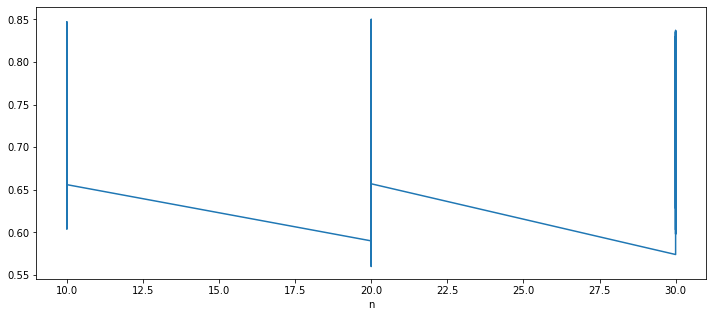

In [89]:
pd.concat([
    df.name.str.replace('e-', 'e^').str.split(r'-', expand=True),
    df.m,
], axis=1).rename(columns={6: 'k'}).set_index('k')['m'].reset_index() \
    .assign(k=lambda x: x['k'].str.replace('^', '-'), regex=False) \
    .assign(n=lambda x: pd.to_numeric(x['k'].str.split('_').str[-1])) \
    .set_index('n').sort_index()['m'].astype(float).plot(figsize=(12, 5))

<ipython-input-90-b97c4d633b64>:5: FutureWarning: The default value of regex will change from True to False in a future version. In addition, single character regular expressions will*not* be treated as literal strings when regex=True.
  .assign(k=lambda x: x['k'].str.replace('^', '-'), regex=False) \


<AxesSubplot:xlabel='n'>

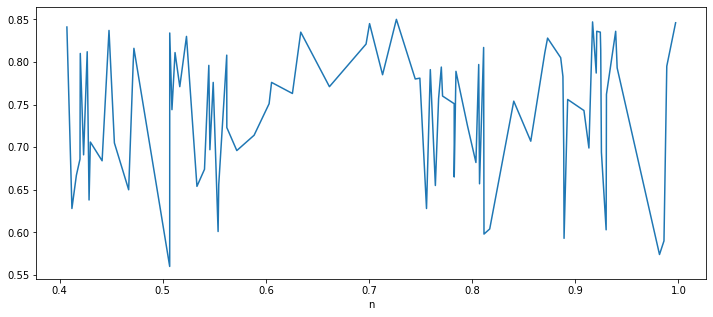

In [90]:
pd.concat([
    df.name.str.replace('e-', 'e^').str.split(r'-', expand=True),
    df.m,
], axis=1).rename(columns={7: 'k'}).set_index('k')['m'].reset_index() \
    .assign(k=lambda x: x['k'].str.replace('^', '-'), regex=False) \
    .assign(n=lambda x: pd.to_numeric(x['k'].str.split('_').str[-1])) \
    .set_index('n').sort_index()['m'].astype(float).plot(figsize=(12, 5))

In [91]:
!cat bin/scen_bt_tuning_1.sh


    export SC_SUFFIX="bt_tuning_lambd_0.006062-hidden_size_2016-prj_size_121-batch_size_32-lr_0.000572-weight_decay_0.001115-step_size_20-step_gamma_0.42003"
    python ../../pl_train_module.py \
        logger_name=${SC_SUFFIX} \
        params.train.lambd=0.006062 \
        params.rnn.hidden_size="2016" \
         "params.head_layers=[[Linear, {in_features: 2016, out_features: 121, bias: false}], [BatchNorm1d, {num_features: 121}], [ReLU, { }], [Linear, {in_features: 121, out_features: 121, bias: false}], [BatchNorm1d, {num_features: 121, affine: False}]]"  \
        data_module.train.batch_size=32 \
        params.train.lr=0.000572 \
        params.train.weight_decay=0.001115 \
        params.lr_scheduler.step_size=20 \
        params.lr_scheduler.step_gamma=0.42003 \
        model_path="models/gender_mlm__$SC_SUFFIX.p" \
        --conf "conf/barlow_twins_params.hocon"
    python ../../pl_inference.py         inference_dataloader.loader.batch_size=500 \
        model_path="models/g